In [63]:
import itertools
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)


In [73]:
GINI_FILE = "/Users/yy/git/national-science-production/Data/Derived/Publication_based/Gini/Normalized/agg_gini_full.csv"
INCOME_FILE = "/Users/yy/git/national-science-production/Data/Derived/Country_metadata/cntry_year_gdp.csv"
CNTRY_CODES = "/Users/yy/git/national-science-production/Data/Additional_data/country_WoS_ECI_WB_flags.tsv"
PERIODS_FILE = "/Users/yy/git/national-science-production/Data/Additional_data/year_intervals.txt"
PLOT_FILE = "/Users/yy/git/national-science-production/Figs/ginirelated/flow_plane/Normalized/diversity_income_flow_full.pdf"

In [74]:
gini_df = pd.read_csv(GINI_FILE)
gini_df.head()

,COUNTRY,GINI,YEAR,ST
0,Afghanistan,0.842701,2008-2012,Others
1,Afghanistan,0.936461,1978-1982,Others
2,Afghanistan,0.914178,2003-2007,Others
3,Afghanistan,0.824282,2013-2017,Others
4,Afghanistan,0.987081,1998-2002,Others


In [75]:
income_df = pd.read_csv(INCOME_FILE).rename(columns={"Year": "YEAR"})
income_df.head()

,Code,YEAR,Income
0,ABW,1973-1977,NaN
1,AFG,1973-1977,2.352889e+09
2,AGO,1973-1977,NaN
3,ALB,1973-1977,NaN
4,AND,1973-1977,2.077614e+08


In [76]:
cntry_code_df = pd.read_csv(CNTRY_CODES, sep="\t")
cntry_code_df.head()

,WoS,ECI_Country,WB,Code
0,Albania,Albania,Albania,ALB
1,Algeria,Algeria,Algeria,DZA
2,Angola,Angola,Angola,AGO
3,Argentina,Argentina,Argentina,ARG
4,Australia,Australia,Australia,AUS


In [77]:
periods = [x.strip() for x in open(PERIODS_FILE)]
periods

['1973-1977',
 '1978-1982',
 '1983-1987',
 '1988-1992',
 '1993-1997',
 '1998-2002',
 '2003-2007',
 '2008-2012',
 '2013-2017']

In [78]:
meta_df = gini_df.merge(
    cntry_code_df[["WoS", "Code"]], 
    left_on="COUNTRY", 
    right_on="WoS"
)[["Code", "GINI", "YEAR", "ST"]].merge(income_df, on=["Code", "YEAR"])

meta_df["Diversity"] = 1 - meta_df["GINI"]
meta_df["log_gdp"] = np.log10(meta_df["Income"])
meta_df = meta_df.dropna()
meta_df.head()

,Code,GINI,YEAR,ST,Income,Diversity,log_gdp
0,AFG,0.842701,2008-2012,Others,1.524216e+10,0.157299,10.183046
1,AFG,0.936461,1978-1982,Others,3.529613e+09,0.063539,9.547727
2,AFG,0.914178,2003-2007,Others,6.534128e+09,0.085822,9.815188
3,AFG,0.824282,2013-2017,Others,2.010149e+10,0.175718,10.303228
4,AFG,0.987081,1998-2002,Others,4.055180e+09,0.012919,9.608010


In [79]:
maxvalue = np.ceil(meta_df.log_gdp.max())
minvalue = np.floor(meta_df.log_gdp.min())
ybins = np.arange(minvalue, maxvalue, 0.5)
ylabels = np.arange(minvalue + 0.5, 14, 0.5)
xbins = np.arange(0, 10, 1) / 10
xlabels = np.arange(1, 10, 1) / 10
xbins, ybins

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 array([ 6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
        11.5, 12. , 12.5, 13. , 13.5]))

In [80]:
meta_df["ybins"] = pd.cut(meta_df["log_gdp"], bins=ybins, labels=ylabels)
meta_df["xbins"] = pd.cut(meta_df["Diversity"], bins=xbins, labels=xlabels)
meta_df.head()

,Code,GINI,YEAR,ST,Income,Diversity,log_gdp,ybins,xbins
0,AFG,0.842701,2008-2012,Others,1.524216e+10,0.157299,10.183046,10.5,0.2
1,AFG,0.936461,1978-1982,Others,3.529613e+09,0.063539,9.547727,10.0,0.1
2,AFG,0.914178,2003-2007,Others,6.534128e+09,0.085822,9.815188,10.0,0.1
3,AFG,0.824282,2013-2017,Others,2.010149e+10,0.175718,10.303228,10.5,0.2
4,AFG,0.987081,1998-2002,Others,4.055180e+09,0.012919,9.608010,10.0,0.1


In [81]:
x_start = []
y_start = []
x_end = []
y_end = []
for xgrid, ygrid in itertools.product(xlabels, ylabels):
    cell_df = meta_df[(meta_df.xbins == xgrid) & (meta_df.ybins == ygrid)]
    cell_df = cell_df[cell_df.YEAR != "2013-2017"]
    current_df = pd.DataFrame()
    next_df = pd.DataFrame()
    for index, row in cell_df.iterrows():
        cntry_code = row["Code"]
        year_crrt = row["YEAR"]
        year_next_index = periods.index(year_crrt) + 1
        cntry_next = meta_df[
            (meta_df.Code == cntry_code)
            & (meta_df.YEAR == periods[year_next_index])
        ]
        if not cntry_next.empty:
            current_df = pd.concat([current_df, cell_df.loc[[index]]])
            next_df = pd.concat([next_df, cntry_next])
    if not current_df.empty:
        x_start.append(current_df.Diversity.mean())
        y_start.append(np.log10(current_df.Income.mean()))

        x_end.append(next_df.Diversity.mean())
        y_end.append(np.log10(next_df.Income.mean()))

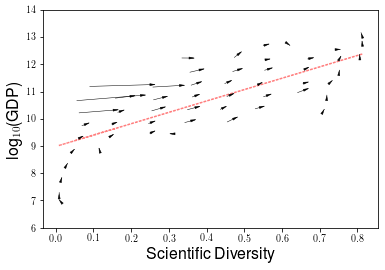

In [122]:
fig, ax = plt.subplots()
for index, value in enumerate(x_start):
    width, length = 0.1, 0.5
    arrowstyle = f"-|>, head_width={width}, head_length={length}"
    
    ax.annotate(
        s="",
        xy=(x_end[index], y_end[index]),
        xytext=(x_start[index], y_start[index]),
        arrowprops=dict(arrowstyle=arrowstyle, 
                        color='black', lw=.5, connectionstyle="arc3"),
    )

xvalue = meta_df["Diversity"].values
yvalue = meta_df["log_gdp"].values
m, b = np.polyfit(xvalue, yvalue, 1)
plt.plot(xvalue, m * xvalue + b, "r:", alpha=0.5)
ax.set_yticks(np.arange(6, 14, 1), minor=True)

plt.ylim(6, 14)
ax.grid(False)
plt.xlabel("Scientific Diversity", fontsize=16)
plt.ylabel(r"log$_{10}$(GDP)", fontsize=16)
plt.savefig(PLOT_FILE)
